In [1]:
# Import Libraries
import numpy as np
import torch
import torchvision.transforms as tvt
import torch.utils.data 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchinfo import summary
from PIL import Image
import os
from pprint import pprint
import seaborn as sns
import cv2
from ViTHelper import MasterEncoder
from einops import repeat
from einops.layers.torch import Rearrange, Reduce
import time
import datetime

/home/dfarache/.conda/envs/cent7/2020.11-py38/eceDL2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GLOBAL VARIABLES
train_dir = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw09/Train"
test_dir = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw09/Val"
path_to_model = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw09/model"
path_to_results = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw09/results"
batch_size = 16

num_classes = 5
class_list = ("airplane", "bus", "cat", "dog", "pizza")
class_to_integer = {"airplane": 0, "bus": 1, "cat": 2, "dog": 3, "pizza": 4}
integer_to_class = {0: "airplane", 1: "bus", 2: "cat", 3: "dog", 4: "pizza"}

patch_size = 16 # 16 pixels
C_in = 3 # Input channels
embedded_size = 128
max_seq_length = patch_size + 1 # account for class token
image_size = 64 # 64x64, h x w

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is on {device}")
device = torch.device(device)

Torch is on cuda


## Generate Dataset

In [3]:
def get_images(root, category):
    category_path = os.path.join(root, category)
    image_files = [image for image in os.listdir(category_path) if image != ".DS_Store"]

    images_pil = [Image.open(os.path.join(category_path, image)).convert("RGB") for image in image_files]
    return images_pil

In [4]:
class GenerateDataset(torch.utils.data.Dataset):
    def __init__(self, root, class_list, transform=None):
        super().__init__()
        self.root = root
        self.class_list = class_list
        self.transform = transform
        self.data = []

        for idx, category in enumerate(self.class_list):
            images = get_images(self.root, category)
            for image in images:
                self.data.append([image, idx])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.transform(self.data[idx][0]) if self.transform else self.data[idx][0]
        label = torch.tensor(self.data[idx][1])

        return image, label

In [5]:
def generate_dataloader(root_path, class_list, debug=False):
    transform = tvt.Compose([tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = GenerateDataset(root_path, class_list, transform=transform)
    if(debug):
        image_size, label = dataset[0][0].shape, dataset[0][1]
        label = integer_to_class[int(label)]
        print(f"Image Shape: {image_size} and Label: {label}")

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    return dataloader

trainloader = generate_dataloader(train_dir, class_list, debug=True)
testloader = generate_dataloader(test_dir, class_list)

Image Shape: torch.Size([3, 64, 64]) and Label: airplane


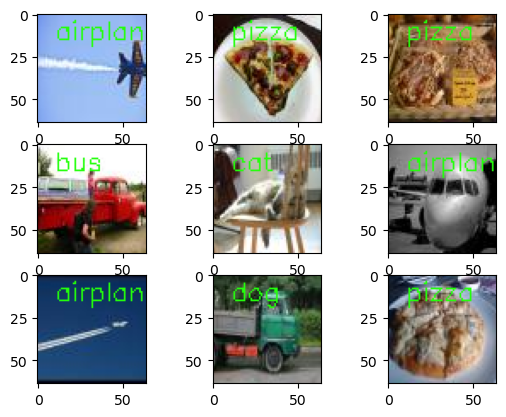

In [6]:
def display_input_images(dataloader):
    fig, ax = plt.subplots(3, 3)
    row, col = 0, 0
    for batch_idx, (images_in_batch, labels_in_batch) in enumerate(dataloader):
        for idx in range(len(labels_in_batch)):
            if(col == 3):
                row += 1
                col = 0
            if(row == 3):
                break
            label = integer_to_class[int(labels_in_batch[idx])]
            image = np.asarray(tvt.ToPILImage()(images_in_batch[idx].squeeze(dim=0) / 2  + 0.5))
            image = cv2.putText(image, label, (10, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(36, 255, 12), thickness=1)
            ax[row, col].imshow(image)
            col += 1
        if(row == 3):
            break

display_input_images(trainloader)

## Networks

In [7]:
# Inspired by: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632
# Inspired by: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c 

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, embedded_size, image_size, in_channels=3):
        super(PatchEmbedding, self).__init__()

        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedded_size = embedded_size
        self.image_size = image_size

        """
        The transformer encoder was developed with sequence data in mind but images are not sequences. So to 'sequencify' an image we break it into
        multiple sub-images and map each sub-image to a vector. This is achieved by reshaping our input from (batch_size, input_channel, height, width)
        to shape (batch_size, patch_height * patch_width, embedded_size) where embedded_size = input_channel * patch_size ** 2
        """
        
        self.sequential = nn.Sequential(
            # Convolutional Network is used for better performance
            nn.Conv2d(in_channels, embedded_size, kernel_size=patch_size, stride=patch_size), # Returns a shape of (batch_size, embedded_size, patch_height, patch_width)
            Rearrange('b e (h) (w) -> b (h w) e') # chance shape from (batch_size, embedded_size, patch_height, patch_width) to (batch_size, patch_height * patch_width, embedded_size)
        )
        
        self.class_token = nn.Parameter(torch.rand(1, 1, self.embedded_size)) # Number placed in front of each sequence
        self.positions = nn.Parameter(torch.randn((self.image_size // self.patch_size)**2 + 1, self.embedded_size)) # The positional embedding allows the network to know where each sub-image is positioned originally in the image

    def forward(self, x):
        x = self.sequential(x)
        class_tokens = repeat(self.class_token, '() n e -> b n e', b=batch_size) # repeating in each batch
        x = torch.cat([class_tokens, x], dim=1) # prepend the class token to the input make it sequence length of 17
        x = x + self.positions
        return x

In [8]:
class ClassificationHead(nn.Sequential):
  # Inspired by: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632
    def __init__(self, embedded_size, num_classes):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.Linear(embedded_size, num_classes))

### Homework

In [9]:
class ViT(nn.Sequential):
    # Inspired by: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632
    def __init__(self, how_many_basic_encoders=2, num_attention_heads=2, in_channels=3):
        super(ViT, self).__init__(
            PatchEmbedding(patch_size, embedded_size, image_size, in_channels), # Returns shape [batch size, max_seq_length, embedded_size]
            MasterEncoder(max_seq_length, embedded_size, how_many_basic_encoders, num_attention_heads), # Returns shape [batch size, max_seq_length, embedded_size]
            ClassificationHead(embedded_size, num_classes) # Returns shape [batch size, num_classes]
        )

In [10]:
# Number of layers and learnable parameters in the Generator
net1 = ViT()
num_layers = len(list(net1.parameters()))
num_learnable_parameters = sum(p.numel() for p in net1.parameters() if p.requires_grad)

print(f"Number of layers in the network: {num_layers}")
print(f"Number of learnable parameters in the network: {num_learnable_parameters}")
summary(net1, input_size=(batch_size, 3, image_size, image_size))

Number of layers in the network: 46
Number of learnable parameters in the network: 52213253


Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [16, 5]                   --
├─PatchEmbedding: 1-1                              [16, 17, 128]             2,304
│    └─Sequential: 2-1                             [16, 16, 128]             --
│    │    └─Conv2d: 3-1                            [16, 128, 4, 4]           98,432
│    │    └─Rearrange: 3-2                         [16, 16, 128]             --
├─MasterEncoder: 1-2                               [16, 17, 128]             --
│    └─ModuleList: 2-2                             --                        --
│    │    └─BasicEncoder: 3-3                      [16, 17, 128]             26,055,936
│    │    └─BasicEncoder: 3-4                      [16, 17, 128]             26,055,936
├─ClassificationHead: 1-3                          [16, 5]                   --
│    └─Reduce: 2-3                                 [16, 128]                 --
│    └─Linea

### Extra Credit

In [11]:
class ViT2(nn.Sequential):
    # Inspired by: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632
    def __init__(self, how_many_basic_encoders=2, num_attention_heads=2, in_channels=3):
        super(ViT2, self).__init__(
            PatchEmbedding(patch_size, embedded_size, image_size, in_channels), # Returns shape [batch size, max_seq_length, embedded_size]
            MasterEncoder(max_seq_length, embedded_size, how_many_basic_encoders, num_attention_heads, task=2), # Returns shape [batch size, max_seq_length, embedded_size]
            ClassificationHead(embedded_size, num_classes) # Returns shape [batch size, num_classes]
        )

In [12]:
# Number of layers and learnable parameters in the Generator
net2 = ViT2()
num_layers = len(list(net2.parameters()))
num_learnable_parameters = sum(p.numel() for p in net2.parameters() if p.requires_grad)

print(f"Number of layers in the network: {num_layers}")
print(f"Number of learnable parameters in the network: {num_learnable_parameters}")
summary(net2, input_size=(batch_size, 3, image_size, image_size))

Number of layers in the network: 46
Number of learnable parameters in the network: 52213253


Layer (type:depth-idx)                             Output Shape              Param #
ViT2                                               [16, 5]                   --
├─PatchEmbedding: 1-1                              [16, 17, 128]             2,304
│    └─Sequential: 2-1                             [16, 16, 128]             --
│    │    └─Conv2d: 3-1                            [16, 128, 4, 4]           98,432
│    │    └─Rearrange: 3-2                         [16, 16, 128]             --
├─MasterEncoder: 1-2                               [16, 17, 128]             --
│    └─ModuleList: 2-2                             --                        --
│    │    └─BasicEncoder: 3-3                      [16, 17, 128]             26,055,936
│    │    └─BasicEncoder: 3-4                      [16, 17, 128]             26,055,936
├─ClassificationHead: 1-3                          [16, 5]                   --
│    └─Reduce: 2-3                                 [16, 128]                 --
│    └─Linea

## Training

In [13]:
def plot_losses(loss, epochs):
    plt.plot(range(len(loss)), loss)

    plt.title(f"Loss per Iteration")
    plt.xlabel(f"Iterations over {epochs} epochs")
    plt.ylabel("Loss")
    plt.legend(loc="lower right")

    filename = "train_loss.jpg"
    plt.savefig(os.path.join(path_to_results, filename))
    plt.show()

In [14]:
def train(net, epochs, lr, betas, dataloader, log=100, mode=True):
    net = net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=betas)
    loss_per_iteration = []
        
    print(f"Training started at time {datetime.datetime.now().time()}")
    start_time = time.time()
    check_loss = float("inf")
    
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if((batch_idx + 1) % log == log-1):
                print("[epoch: %d, batch: %5d] loss: %.3f" % (epoch, batch_idx + 1, running_loss / log))
                loss_per_iteration.append(running_loss / log)

                if(running_loss < check_loss):
                    model_name = "model1.pth" if mode else "model2.pth"
                    torch.save(net.state_dict(), os.path.join(path_to_model, model_name))
                    check_loss = running_loss
                running_loss = 0.0
    
    print("Lowest loss achieved by network: %.4f" % (check_loss / float(log)))
    print("Training finished in %4d secs" % (time.time() - start_time))
    return loss_per_iteration

In [15]:
# Parameters for training 
lr = 1e-4 # Learning Rate
betas = (0.9, 0.999) # Betas factor
epochs = 20 # Number of epochs to train

### Homework

Training started at time 01:24:23.670707
[epoch: 1, batch:    99] loss: 1.358
[epoch: 1, batch:   199] loss: 1.285
[epoch: 1, batch:   299] loss: 1.257
[epoch: 1, batch:   399] loss: 1.221
[epoch: 2, batch:    99] loss: 1.159
[epoch: 2, batch:   199] loss: 1.126
[epoch: 2, batch:   299] loss: 1.146
[epoch: 2, batch:   399] loss: 1.198
[epoch: 3, batch:    99] loss: 1.072
[epoch: 3, batch:   199] loss: 1.151
[epoch: 3, batch:   299] loss: 1.090
[epoch: 3, batch:   399] loss: 1.089
[epoch: 4, batch:    99] loss: 1.058
[epoch: 4, batch:   199] loss: 1.059
[epoch: 4, batch:   299] loss: 1.078
[epoch: 4, batch:   399] loss: 1.022
[epoch: 5, batch:    99] loss: 0.959
[epoch: 5, batch:   199] loss: 0.962
[epoch: 5, batch:   299] loss: 0.981
[epoch: 5, batch:   399] loss: 1.021
[epoch: 6, batch:    99] loss: 0.848
[epoch: 6, batch:   199] loss: 0.913
[epoch: 6, batch:   299] loss: 0.923
[epoch: 6, batch:   399] loss: 0.936
[epoch: 7, batch:    99] loss: 0.791
[epoch: 7, batch:   199] loss: 0.7

No handles with labels found to put in legend.


Lowest loss achieved by network: 0.0748
Training finished in  268 secs


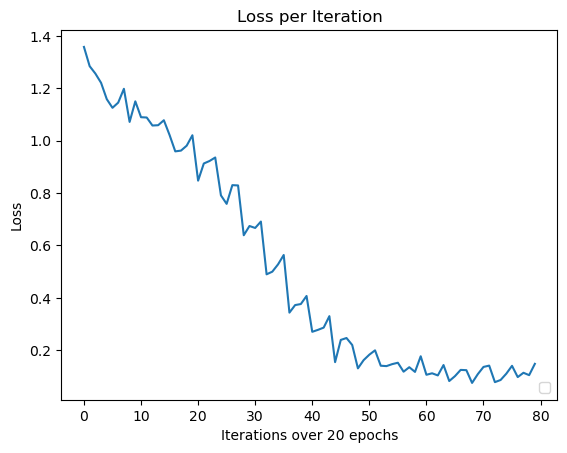

In [16]:
training_loss = train(net1, epochs, lr, betas, trainloader)
plot_losses(training_loss, epochs)

### Extra Credit

Training started at time 01:28:52.955506
[epoch: 1, batch:    99] loss: 1.369
[epoch: 1, batch:   199] loss: 1.265
[epoch: 1, batch:   299] loss: 1.259
[epoch: 1, batch:   399] loss: 1.233
[epoch: 2, batch:    99] loss: 1.185
[epoch: 2, batch:   199] loss: 1.195
[epoch: 2, batch:   299] loss: 1.153
[epoch: 2, batch:   399] loss: 1.135
[epoch: 3, batch:    99] loss: 1.122
[epoch: 3, batch:   199] loss: 1.102
[epoch: 3, batch:   299] loss: 1.098
[epoch: 3, batch:   399] loss: 1.076
[epoch: 4, batch:    99] loss: 0.999
[epoch: 4, batch:   199] loss: 1.085
[epoch: 4, batch:   299] loss: 1.052
[epoch: 4, batch:   399] loss: 1.073
[epoch: 5, batch:    99] loss: 0.953
[epoch: 5, batch:   199] loss: 0.994
[epoch: 5, batch:   299] loss: 0.985
[epoch: 5, batch:   399] loss: 1.026
[epoch: 6, batch:    99] loss: 0.902
[epoch: 6, batch:   199] loss: 0.866
[epoch: 6, batch:   299] loss: 0.920
[epoch: 6, batch:   399] loss: 0.919
[epoch: 7, batch:    99] loss: 0.778
[epoch: 7, batch:   199] loss: 0.7

No handles with labels found to put in legend.


Lowest loss achieved by network: 0.0839
Training finished in  296 secs


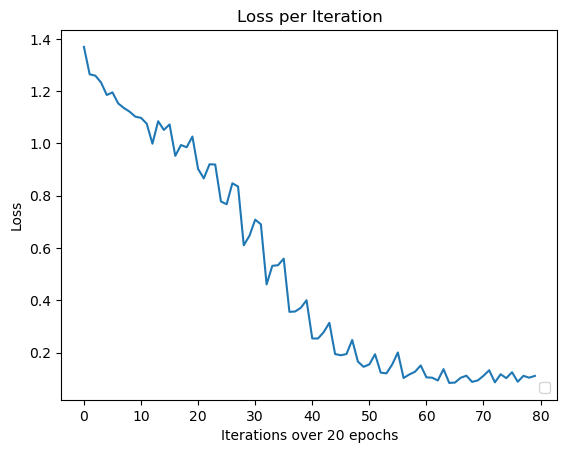

In [17]:
training_loss = train(net2, epochs, lr, betas, trainloader, mode=False)
plot_losses(training_loss, epochs)

## Testing

In [18]:
def test(net, path_to_network, dataloader, num_classes, mode=True):
    model_name = "model1.pth" if mode else "model2.pth"
    net.load_state_dict(torch.load(os.path.join(path_to_network, model_name)))
    net = net.to(device)
    confusion_matrix = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, dim=1)
            for label, prediction in zip(labels, predicted):
                confusion_matrix[label][prediction] += 1
            
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    return confusion_matrix, accuracy

In [19]:
def display_confusion_matrix(conf, class_list, accuracy):
    sns.heatmap(conf, xticklabels=class_list, yticklabels=class_list, annot=True)
    plt.xlabel(f"True Label \n Accuracy: {accuracy}")
    plt.ylabel("Predicted Label")

    filename = "conf.jpg"
    plt.savefig(os.path.join(path_to_results, filename))
    plt.show()

### Homework

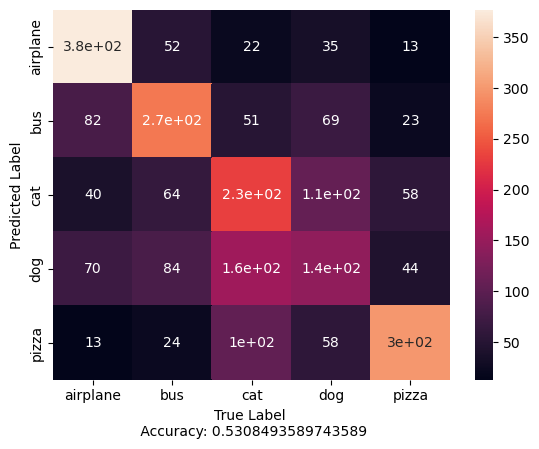

In [20]:
confusion_matrix, accuracy = test(net1, path_to_model, testloader, num_classes)
display_confusion_matrix(confusion_matrix, class_list, accuracy)

### Extra Credit

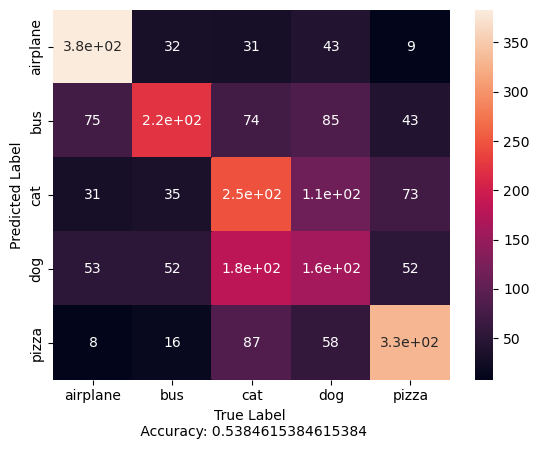

In [21]:
confusion_matrix, accuracy = test(net2, path_to_model, testloader, num_classes, mode=False)
display_confusion_matrix(confusion_matrix, class_list, accuracy)